# Setup libraries

In [3]:
import spacy
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random
%matplotlib notebook

# Setup important variables

In [4]:
subsample = 500 # Use a subsample of the data
nlp = spacy.load('en')
path_inputs = os.path.join('data', 'cases')
path_labels = os.path.join('data')
filenames = random.sample([filename for filename in os.listdir(path_inputs)], subsample)

# Parse all documents once and store parsed versions

In [5]:
parsed_docs = []
for filename in filenames:
    with open(os.path.join(path_inputs, filename)) as f:
        doc = nlp(f.read())
        parsed_docs.append(doc)

# Count the number of sentences, words and letters for each document

In [6]:
df = pd.DataFrame(columns=['Sentences', 'Words', 'Letters']).astype(np.int64)

for doc in parsed_docs:
    # Count
    sentences = len(list(doc.sents))
    words = 0
    letters = 0
    for token in doc:
        if not token.is_space and not token.is_punct:
            words += 1
            letters += len(token.text)
    # Add to dataframe
    new_entry = {'Sentences': sentences, 'Words': words, 'Letters': letters}
    df = df.append(new_entry, ignore_index=True)

# Histogram for the computed statistics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x104670550>,
      dtype=object)

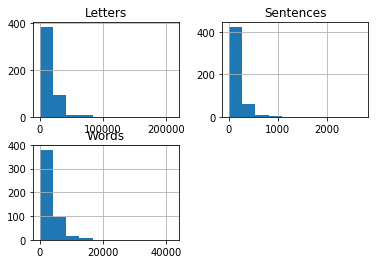

In [7]:
df.hist()

# Count nouns, verbs, adjectives in each document

In [8]:
# first 4 letter of filenames is the year
years = list(set(([int(filename[:4]) for filename in filenames])))
dfPOS = pd.DataFrame(np.zeros((len(years), 3)), index=years, columns=['Nouns', 'Verbs', 'Adjectives']).astype(np.int64)
dfPOS.sort_index(inplace=True)

for filenameidx, doc in enumerate(parsed_docs):
    # Count
    nouns = 0
    adjectives = 0
    verbs = 0
    year = int(filenames[filenameidx][:4])
    for token in doc:
        if token.pos_ == 'VERB':
            verbs += 1
        elif token.pos_ == 'NOUN':
            nouns += 1
        elif token.pos_ == 'ADJ':
            adjectives += 1
    # Add to dataframe
    new_entry = dfPOS.loc[year]
    new_entry['Nouns'] += nouns
    new_entry['Adjectives'] += adjectives
    new_entry['Verbs'] += verbs
    dfPOS.loc[year] = new_entry

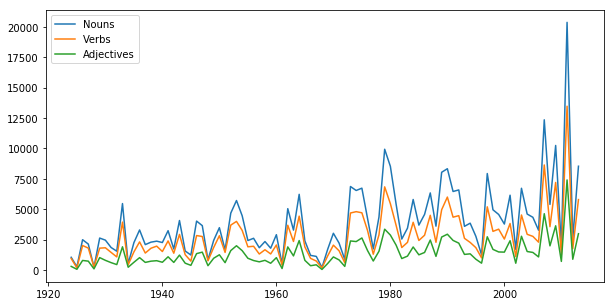

In [9]:
# Visualize POS frequency by year
dfPOS.plot(figsize=(10,5))

# Normalizing corpus

We remove punctuation as well as whitespace as they are not useful in creating trigrams.
We also remove stop words as they don't change the context we want to capture with trigrams.
We also use lemmatization to match different inflectional forms of the the same words without changing the part of speech of the word.

In [10]:
# Count occurences of each normalized trigram that ends in a noun
trigram_count = {}
# Indices
LEMMA = 0
POS = 1 # part-of-speech

for doc in parsed_docs:
    toks = [(token.lemma_, token.pos_) for token in doc if not token.is_space if not token.is_punct if not token.is_stop]
    for i in range(len(toks)):
        if i < 2:
            continue # start from 3rd token
        pos = toks[i][POS]
        if (pos == 'NOUN'):
            trigram = (toks[i][LEMMA], toks[i - 1][LEMMA], toks[i - 2][LEMMA])
            if trigram in trigram_count:
                trigram_count[trigram] += 1
            else:
                trigram_count[trigram] = 1

# Select top 1000 trigrams as features

In [11]:
TOP = 1000
# sort descending by the value(count) and select the first TOP as the features
top_trigrams, _ = map(list, zip(*(sorted(list(trigram_count.items()), key=lambda x: -x[1])[:TOP])))

# Create a dataframe using the 1000 trigram features for each document

In [12]:
# Extract case names
cases = sorted(list(([filename[5:-4] for filename in filenames])))

# Dataframe to hold counts for each trigram feature
dfTRI = pd.DataFrame(np.zeros((len(cases), len(top_trigrams))), index=cases, columns=top_trigrams).astype(np.int64)

for filenameidx, doc in enumerate(parsed_docs):
    toks = [(token.lemma_, token.pos_) for token in doc if not token.is_space if not token.is_punct if not token.is_stop]
    for i in range(len(toks)):
        if i < 2:
            continue # start from 3rd token
        pos = toks[i][POS]
        if (pos == 'NOUN'):
            trigram = (toks[i][LEMMA], toks[i - 1][LEMMA], toks[i - 2][LEMMA])
            if trigram in top_trigrams:
                dfTRI.at[filenames[filenameidx][5:-4], trigram] += 1
                

# Normalize the dataframe to have unit variance per feature
We keep me the mean as it is in order to maintain spasity

In [13]:
dfTRI_normalized = dfTRI / dfTRI.std()

# Load case_reversed.csv

In [14]:
df_reverse = pd.read_csv(os.path.join(path_labels, 'case_reversed.csv')).set_index('caseid').loc[cases]

# Class balance test

In [15]:
count = 0
total = 0
for index, row in df_reverse.iterrows():
    total += 1
    if row.case_reversed:
        count += 1
        
print("TOTAL:",total)
print("CLASS 0:",total-count)
print("CLASS 1:",count)

TOTAL: 500
CLASS 0: 176
CLASS 1: 324


# Split train and test data, apply logistic regression and print accuracy and F1 score

In [16]:
X_train, X_test, y_train, y_test = train_test_split(dfTRI_normalized, df_reverse, test_size=0.15)
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train.case_reversed)
y_pred = clf.predict(X_test)

print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Accuracy score {}'.format(accuracy_score(y_test, y_pred)))

F1 score: 0.702127659574468
Accuracy score 0.6266666666666667


# GridsearchCV to choose l1 vs l2 penalty and regularization parameter C

In [17]:
from sklearn.model_selection import GridSearchCV
parameters = {'penalty':('l1', 'l2'), 'C':[0.1, 2]}
logistic = LogisticRegression(solver='liblinear')
clf = GridSearchCV(logistic, parameters, cv=5, iid=True)
clf.fit(X_train, y_train.case_reversed)
print("The model selected is:")
print(clf.get_params()['estimator'])
print()
print("Training score: {}".format(clf.score(X_train, y_train)))
print("Test score: {}".format(clf.score(X_test, y_test)))

The model selected is:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Training score: 0.7976470588235294
Test score: 0.6266666666666667


# Plot ROC curve and calculate AUC graph for model selected

AUC:  0.6059654631083202


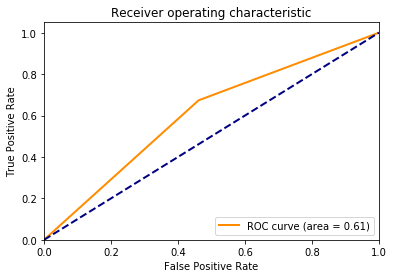

In [18]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# New dataframe where each sentence is a separate document


In [19]:
df_sent = pd.DataFrame(columns=['txt']).astype(str)
for doc in parsed_docs:
    for sent in doc.sents:
        df_sent = df_sent.append({'txt':sent.text}, ignore_index=True)

# Compute vader compund sentiment scores and report top 10 highest- and lowest-sentiment sentences

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_analyzer = SentimentIntensityAnalyzer()
best = []
worst = []
TOPELEMS = 10 # top 10 best and worst

for _, row in df_sent.iterrows():
    sent = row.txt
    score = sentiment_analyzer.polarity_scores(sent)['compound']
    if len(best) < TOPELEMS or score > best[-1][0]:
        if len(best) >= TOPELEMS:
            best.pop()
        pos = 0
        for sc, _ in best:
            if sc > score:
                break
            pos += 1
        best.insert(pos, (score, sent))

    if len(worst) < TOPELEMS or score < worst[-1][0]:
        if len(worst) >= TOPELEMS:
            worst.pop()
        pos = len(worst)
        for i in range(len(worst)):
            sc  =  worst[len(worst) - 1- i][0]
            if sc < score:
                break
            pos -= 1
        worst.insert(pos, (score, sent))
               
            
print("BEST")
best.reverse()
print(best)
print('------------------\n')
print("WORST")
print(worst)


BEST
[(0.9871, 'It is the theory of petitioner as to this and the other trusts that he parted with all his interest in the securities transferred to the trustee; that the trustee under the terms of the trust was authorized and directed to use the income from these securities which constituted the corpus of the trust to pay premiums upon insurance policies on the life of the grantor, which policies were transferred to the trustee, with no right on the part of petitioner to change the beneficiary named therein, the trustee; that all control over the securities and the policies of insurance was with the trustee, and no control whatever reserved to petitioners; that under the terms of the various trusts he had no right to revoke the same; that the conveyance of the corpus of the trust was absolute and the ownership of the insurance policies became absolute in the trustee; that the trusts were created and completed prior to the passage of the act under which respondent assessed taxes to pet

# Calculate cosine similarity of sentences using tfidf

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
corpus = list(df_sent['txt'])
corpus_tfidf = vectorizer.fit_transform(corpus)
similarity_matrix = cosine_similarity(corpus_tfidf)

# Find 5 very similar and very dissimilar sentences according to the similarity matrix

In [22]:
NUMBER = 5
similar = []
similar_threshold = 0.50
dissimilar = []
dissimilar_threshold = 0.05

found = 0
for i in range(len(corpus)):
    for j in range(i + 1, len(corpus)):
        if similarity_matrix[i][j] > similar_threshold:
            print('SIMILAR:')
            print(corpus[i])
            print(corpus[j])
            print('Score: ', similarity_matrix[i][j])
            print()
            found += 1
            break # use a different sentence
    if found >= NUMBER:
        break
         
            
found = 0         
for i in range(len(corpus)):
    for j in range(i + 1, len(corpus)):
        if similarity_matrix[i][j] < dissimilar_threshold:
            print('DISSIMILAR:')
            print(corpus[i])
            print(corpus[j])
            print('Score: ', similarity_matrix[i][j])
            print()
            found += 1
            break # use a different sentence
    if found >= NUMBER:
        break

SIMILAR:
 PER CURIAM:
 PER CURIAM.

Score:  1.0000000000000002

SIMILAR:
624 (1967).

See 7 C.F.R. 624.1-624.11 (2008).

Score:  0.6497634789554351

SIMILAR:
Accordingly, we affirm the orders of the Securities and Exchange Commission and reverse on the merits the judgment of the District Court in favor of the Investment Company Institute.

Accordingly, we affirm the judgment of the district court.

Score:  0.5430079683796598

SIMILAR:
It is so ordered.

v. So.
Score:  0.504533574705133

SIMILAR:
The opinion of Judge BURGER, in which Judge MILLER concurs, and the [**243] opinion of Chief Judge BAZELON, which follow, set forth the reasons for our action:

 BAZELON , Chief Judge:
Score:  0.5096273713075583

DISSIMILAR:
 PER CURIAM:
In these appeals the mutual fund industry levels a two-pronged attack on a national bank's authority to operate a collective investment fund as a service of its trust department.

Score:  0.0

DISSIMILAR:
In these appeals the mutual fund industry levels a two-p

# Use k-means clustering to assign the sentences into 20 clusters

In [23]:
from sklearn.cluster import KMeans
NCLUSTERS = 20
# Use tfidf scores for clustering
kmeans = KMeans(n_clusters=NCLUSTERS, random_state=0).fit(corpus_tfidf)

# List 5 example sentences from each cluster


In [24]:
npcorp = np.array(corpus, dtype=str)
for cluster_no in range(1,NCLUSTERS,1):
    print('Cluster {}'.format(cluster_no))
    this_cluster = npcorp[kmeans.labels_ == cluster_no]
    if this_cluster.shape[0] > 5:
        this_cluster = np.random.choice(this_cluster, 5)
    for sent in this_cluster:
        print(sent)

Cluster 1
3037 , 168 L.Ed.2d
988 ; Goodman v. Niblack , 102 U.S. 556, 559 , 26 L.Ed. 229 ; McKnight v. United States , supra [ 98 U.S. 179 , 25 L.Ed. 115 ]; Erwin v. United States , 97 U.S. 392 , 24 L.Ed. 1065 .

630 , 60 L.Ed.
88 L.Ed.
158 , 100 L.Ed.
Cluster 2
Id .

Id .

Id. 300gg(a)(1) .

Id .

Id .

Cluster 3
Alternatively, the jury might have concluded that comparing the date of birth, as listed in the sheriff's files, with the date of birth on plaintiff's driver's license when he was arrested in Dallas was a sufficient safeguard against arresting and detaining the wrong person and that it was reasonable for the sheriff not to require his deputies to take the additional precaution of sending the photographs and fingerprints.

12 Mitchell also informed Jalovec that Hampton and Johnson were living at the apartment, that other members of the BPP frequented the apartment, and that a variety of weapons, illegally purchased, was kept there.

Plaintiffs reply that the old scheme was onl